In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm, chi2
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from matplotlib import gridspec
import os
import json
from matplotlib import rc
import re

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "times"
})

In [2]:
def read_inputs(results_path, cov_csv_path, renormalise, add_theory_uncertainties, print_config):

    with open(results_path, "r") as f:
        input_data = json.load(f)
    
        experiment = input_data["experiment"]
        bin_edges = np.array(input_data["bin_edges"])
        bin_centers = np.array(input_data["bin_centers"])
        observable_name = str(results_path.split(".")[0].split("_")[0]) 
        observable_name_tex = input_data["observable_name_tex"]
        y_lims = input_data["y_lims"]
        ratio_y_lims = input_data["ratio_y_lims"]
        legend_pos = input_data["legend_pos"]
        ratio_legend_pos = input_data["ratio_legend_pos"]
        x_axis_title = input_data["x_axis_title"]
        data_values = np.array(input_data["data_values"])
        total_uncertainties = np.array(input_data["total_uncertainties"])
        n_bins = len(data_values)
        NNLO_values = np.array(input_data["NNLO_values"])
        NNLO_toponium_values = np.array(input_data["NNLO_toponium_values"])
        Total_uncertainty_upper = np.array(input_data["Total_uncertainty_upper"])
        Total_uncertainty_lower = np.array(input_data["Total_uncertainty_lower"])
        fit_limits = input_data["fit_limits"]

    if(print_config == True):
        for key, value in input_data.items():
            print(key, value)

    bin_widths = np.diff(bin_edges)
    area_nnlo = np.sum(NNLO_values * bin_widths)
    area_top = np.sum(NNLO_toponium_values * bin_widths)
    area_data = np.sum(data_values * bin_widths)

    if (renormalise == True): # Normalize theory using bin widths
        NNLO_values /= area_nnlo
        NNLO_toponium_values /= area_top
        data_values /= area_data

    # Load or construct covariance matrix
    cov_matrix = np.zeros((n_bins, n_bins))

    if os.path.exists(cov_csv_path):
        print(f'Using full covariance from: {cov_csv_path}')
        
        with open(cov_csv_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or not line[0].isdigit():
                    continue  # skip headers or malformed lines
                parts = line.split(',')
                if len(parts) != 3:
                    continue
                try:
                    i, j, val = int(float(parts[0])) - 1, int(float(parts[1])) - 1, float(parts[2])
                    cov_matrix[i, j] = val
                    cov_matrix[j, i] = val 
                except ValueError:
                    continue
      
    elif (cov_csv_path == "") :
        print('No covariance file found — using diagonal matrix.')
        cov_matrix = np.diag(total_uncertainties**2)

    cov_matrix_full = cov_matrix

    return input_data, data_values, NNLO_values, NNLO_toponium_values, cov_matrix_full

In [3]:
def chi2_fit(input_data, data, theory_top, theory_nnlo, cov_matrix):

    # Define toponium-only component and chi-squared function
    toponium_component = theory_top[:-1] - theory_nnlo[:-1]
    toponium_component_full = theory_top - theory_nnlo

    cov_matrix = cov_matrix[:-1, :-1] 
    inv_cov = np.linalg.inv(cov_matrix)

    #simple models with variable toponium cross section w/ and w/o last bin 
    def model(alpha):
        return theory_nnlo[:-1] + alpha * toponium_component

    def model_allbins(alpha):
        return theory_nnlo + alpha * toponium_component_full

    def chi2(alpha, data):
        residual = data[:-1] - model(alpha)
        return residual @ inv_cov @ residual

    # Scan over alpha to compute delta chi-squared
    alpha_range = np.linspace(input_data["fit_limits"][0], input_data["fit_limits"][1], 100)
    chi2_vals = [chi2(alpha, data) for alpha in alpha_range]

    best_fit_chi2 = np.min(chi2_vals)
    best_fit_val = alpha_range[np.argmin(chi2_vals)]

    delta_chi2 = chi2_vals - best_fit_chi2
    fitted_prediction = model_allbins(best_fit_val)

    # 68% confidence interval corresponds to delta chi2 = 1, Interpolate for visual clarity
    alpha_low = float(interp1d(delta_chi2[:np.argmin(delta_chi2)], alpha_range[:np.argmin(delta_chi2)], kind='linear', fill_value="extrapolate")(1))
    alpha_high = float(interp1d(delta_chi2[np.argmin(delta_chi2):], alpha_range[np.argmin(delta_chi2):], kind='linear',fill_value="extrapolate")(1))

    return alpha_range, delta_chi2, best_fit_val, alpha_low, alpha_high, fitted_prediction

In [4]:
def plot_chi2_fit_result(input_data, results_path, alpha_range, delta_chi2, best_fit_val, alpha_low, alpha_high):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(alpha_range, delta_chi2, label=r'$\Delta \chi^2(\alpha)$')
    ax.axhline(1.0, color='gray', linestyle='--', label=r'68% CL ($\Delta \chi^2 = 1$)')
    ax.axvline(best_fit_val, color='red', linestyle='--', label=f'Best-fit alpha = {best_fit_val:.2f}')
    ax.axvspan(alpha_low, alpha_high, color='red', alpha=0.2, label=f'68% CI: [{alpha_low:.2f}, {alpha_high:.2f}]')
    ax.set_xlabel(r'$\alpha$', ha='right')
    ax.set_ylabel(r'$\Delta \chi^2$', ha='right')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.close(fig)
    observable_name = str(results_path.split(".")[0].split("_")[0]) 
    output_path = f"{observable_name}_results.txt"

    with open(output_path, "w") as f:
        f.write(input_data["experiment"] + "\n")
        f.write(input_data["observable_name_tex"] + "\n" )
        f.write("result = " + str(best_fit_val) + " + " + str(float(alpha_high) - best_fit_val) + " - " + str(abs(best_fit_val - float(alpha_high) )) + "\n")

    print(f"Results saved to: {output_path}")

In [5]:
def plot_predictions_and_data(results_path, input_data, data_values, NNLO_values, NNLO_toponium_values, cov_matrix, fitted_prediction):
    fig = plt.figure(figsize=(8, 8))  # Taller figure for 3 panels
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])
    gs.update(hspace=0.0)  # No vertical spacing between panels

    experiment = input_data["experiment"]
    bin_edges = np.array(input_data["bin_edges"])
    total_uncertainties = np.array(input_data["total_uncertainties"])
    observable_name_tex = input_data["observable_name_tex"]
    y_lims = input_data["y_lims"]
    ratio_y_lims = input_data["ratio_y_lims"]
    legend_pos = input_data["legend_pos"]
    ratio_legend_pos = input_data["ratio_legend_pos"]
    x_axis_title = input_data["x_axis_title"]

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # --- Top Panel: Data + Theory ---
    ax0 = plt.subplot(gs[0])
    ax0.errorbar(bin_centers, data_values, yerr=total_uncertainties, fmt='o', color='black', label=f"{experiment} Data")

    for i in range(len(bin_edges) - 1):
        ax0.hlines(NNLO_values[i], bin_edges[i], bin_edges[i+1], color='blue', linestyle='--', label='NNLO' if i == 0 else "")
        ax0.hlines(NNLO_toponium_values[i], bin_edges[i], bin_edges[i+1], color='red', linestyle='--', label='NNLO + $\\eta_{t}$' if i == 0 else "")
        ax0.hlines(fitted_prediction[i], bin_edges[i], bin_edges[i+1], color='green', linestyle='--', label='NNLO + $\\hat{\\eta_{t}}$' if i == 0 else "")

    ax0.set_ylabel(observable_name_tex, labelpad=12, loc='top', fontsize=22)
    ax0.set_ylim(y_lims)
    ax0.tick_params(axis='y', pad=6)  # move upper panel y labels slightly right
    ax0.tick_params(labelbottom=False)
    ax0.legend(loc=legend_pos, frameon=False)

    # --- Optional 2D vertical lines and region labels ---
    if input_data.get("type") == "2D":
        coarse_edges = input_data.get("coarse_bin_edges", [])
        coarse_labels = input_data.get("coarse_bin_labels", [])
        if coarse_edges and coarse_labels:
            for i in range(1, len(coarse_edges) - 1):
                #ax0.axvline(x=bin_edges[int(coarse_edges[i])], color='gray', linestyle='dashed', linewidth=1)
                ax0.axvline(x=coarse_edges[i], color='gray', linestyle='dashed', linewidth=1)

            y_text = y_lims[0] +0.00015
            for i in range(len(coarse_labels)):
                start = coarse_edges[i]
                end = coarse_edges[i + 1]
                center_x = 0.5 * (start + end)
                ax0.text(center_x, y_text, coarse_labels[i], ha='center', va='top', fontsize=10)

    # --- Middle Panel: Sensitivity ---
    axS = plt.subplot(gs[1], sharex=ax0)

    sensitivity = (np.array(NNLO_toponium_values) - np.array(NNLO_values)) / total_uncertainties
    axS.step(bin_edges, np.append(sensitivity, sensitivity[-1]), where='post', color='black', label='')
    axS.axhline(0, color='black', linewidth=1)
    axS.set_ylabel("$\\frac{\\eta_{t}}{\\mathrm{Total \; uncertainty}}$ ", fontsize=18)
    axS.set_ylim(-max(1, np.max(np.abs(sensitivity)) * 1.1), max(1, np.max(np.abs(sensitivity)) * 1.1))
    axS.tick_params(labelbottom=False, labelsize=14)

    # --- Bottom Panel: Ratio ---
    ax1 = plt.subplot(gs[2], sharex=ax0)

    ratio_nnlo = np.array(data_values) / np.array(NNLO_values)
    ratio_top = np.array(data_values) / np.array(NNLO_toponium_values)
    ratio_fit = np.array(data_values) / np.array(fitted_prediction)
    ratio_err = total_uncertainties / np.array(NNLO_values)

    for i in range(len(bin_edges) - 1):
        x0, x1 = bin_edges[i], bin_edges[i+1]
        y0, y1 = 1 - ratio_err[i], 1 + ratio_err[i]
        ax1.fill_between([x0, x1], [y0, y0], [y1, y1], step='post', color='orange', alpha=0.6,
                         linewidth=0, label='Total uncertainty' if i == 0 else None)
        ax1.hlines(ratio_nnlo[i], x0, x1, color='blue', linestyle='--', label='_nolegend_' if i > 0 else "NNLO")
        ax1.hlines(ratio_top[i], x0, x1, color='red', linestyle='--', label='_nolegend_' if i > 0 else "NNLO + $\\eta_{t}$")
        ax1.hlines(ratio_fit[i], x0, x1, color='green', linestyle='--', label='_nolegend_' if i > 0 else "NNLO + $\\hat{\\eta_{t}}$")

    ax1.axhline(1.0, color='black', linewidth=1)
    ax1.set_xlabel(x_axis_title, ha='right', x=1.0, labelpad=12, fontsize=22)
    ax1.set_ylabel("$\\frac{\\mathrm{Data}}{\\mathrm{Prediction}}$ ", fontsize=18)
    ax1.tick_params(axis='y', pad=12)  # move upper panel y labels slightly right
    ax1.set_xlim(bin_edges[0], bin_edges[-1])
    ax1.set_ylim(ratio_y_lims)
    ax1.legend(loc=ratio_legend_pos, frameon=False, fontsize=11, ncol=2)  # Two-column legend

    plt.tight_layout()
    observable = str(results_path.split(".")[0].split("_")[0])
    plt.savefig(f"{experiment}_{observable}.pdf", format='pdf', bbox_inches='tight')
    plt.close(fig)


In [6]:
def run_toys(data_values, NNLO_values, NNLO_toponium_values, cov_matrix):

    q_null_toys = []
    q_alt_toys = []

    rng = np.random.default_rng(seed=42)

    cov_matrix_full = cov_matrix.copy()

    cov_matrix = cov_matrix[:-1, :-1]
    inv_cov = np.linalg.inv(cov_matrix)

    #########################################
    #### Generate  distribution of q via toys
    #########################################
    for _ in range(50000):
        #get lr in null hypothesis
        toy_null = rng.multivariate_normal(mean=NNLO_values, cov=cov_matrix_full) #toys in null hypothesis
        delta_null = toy_null - NNLO_values
        chi2_null = delta_null[:-1] @ inv_cov @ delta_null[:-1]
        delta_alt = toy_null - NNLO_toponium_values
        chi2_alt = delta_alt[:-1] @ inv_cov @ delta_alt[:-1]  
    
        lr = math.exp(-0.5*(chi2_alt - chi2_null))
        q_null_toys.append(lr)

        #get lr in alt hypothesis
        toy_alt = rng.multivariate_normal(mean=NNLO_toponium_values, cov=cov_matrix_full) #toys in alt hypothesis
        delta_null = toy_alt - NNLO_values
        chi2_null = delta_null[:-1] @ inv_cov @ delta_null[:-1]
        delta_alt = toy_alt - NNLO_toponium_values
        chi2_alt = delta_alt[:-1] @ inv_cov @ delta_alt[:-1]  
        
        lr = math.exp(-0.5*(chi2_alt - chi2_null))
        q_alt_toys.append(lr)
        
    q_null_toys = np.array(q_null_toys)
    q_alt_toys = np.array(q_alt_toys)

    #########################################
    #### Calculate q for data
    #########################################

    delta_data_null = data_values - NNLO_values
    chi2_data_null = delta_data_null[:-1] @ inv_cov @ delta_data_null[:-1]
 
    delta_data_alt = data_values - NNLO_toponium_values 
    chi2_data_alt = delta_data_alt[:-1] @ inv_cov @ delta_data_alt[:-1]

    q_data = math.exp(-0.5*(chi2_data_alt - chi2_data_null))

    p_val_null = np.mean(q_null_toys >= q_data)
    Z_val_null = norm.isf(p_val_null)

    p_val_alt = np.mean(q_alt_toys >= q_data)
    Z_val_alt = norm.isf(p_val_alt)

    BF = q_data

    return q_null_toys, q_alt_toys, q_data, p_val_null, p_val_alt, Z_val_null , Z_val_alt 

In [7]:
def plot_toys(results_path, q_null_toys, q_alt_toys, q_data, p_val_null, p_val_alt, Z_val_null , Z_val_alt):

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = np.linspace(q_alt_toys.min(), max(q_alt_toys.max(), q_data) + 1, 50) 

    ax.hist(q_null_toys, bins=bins, alpha=0.6, label="Toys under null", histtype="stepfilled")
    ax.hist(q_alt_toys, bins=bins, alpha=0.6, label="Toys under alt", histtype="stepfilled")
    ax.axvline(q_data, color="red", linestyle="--", label=f"Observed $q$ = {q_data:.2f}")
    ax.set_yscale("log")
    ax.set_xlabel(r"$q = e^{ -\frac{1}{2} ( \chi^2_{\mathrm{H_{nr + \eta}}} - \chi^2_{\mathrm{H_{nr}}} ) } $", ha='right')
    ax.set_ylabel("Toy count")
    name = results_path.split("_")[0]
    ax.set_title(f"{name}: Null pv = {p_val_null:.3g}, Z = {Z_val_null:.2f} sigma, Alt:  pv = {p_val_alt:.3g}, Z = {Z_val_alt:.2f} sigma ")
    ax.legend(frameon=False)
    plt.tight_layout()
    plot_name = results_path.split("_")[0] + "_toys.pdf"
    plt.savefig(plot_name, format='pdf', bbox_inches='tight')

    observable_name = str(results_path.split(".")[0].split("_")[0]) 
    output_path = f"{observable_name}_stats.txt"

    with open(output_path, "w") as f:

        f.write(input_data["experiment"] + "\n")
        f.write(input_data["observable_name_tex"] + "\n" )
        f.write("p-val null = " + str(p_val_null) +  " p-val alt = " + str(p_val_alt) +  " z-val null = " + str(Z_val_null)  +  " z-val alt = " + str(Z_val_alt)  + " q_data = " + str(q_data) + "\n")

    print(f"Results saved to: {output_path}")


In [8]:
def make_summary_plot(result_files):

    nt_xs = 6.93 #is this correct?
    nt_xs_measured = 9.0 #is this correct?

    observable_map = {
        "mllatlas":        (r"$\frac{d \sigma_{tt}}{d m_{\ell \ell} }$", 'pink', 0.02, 0.09),
        "mllcms":        (r"$\frac{d \sigma_{tt}}{d m_{\ell \ell} }$", 'orange', 0.12, 0.19),
        "delphillatlas":   (r"$\frac{d \sigma_{tt}}{d \Delta \phi (\ell \ell) }$", 'blue', 0.22, 0.29),
        "delphillcms":   (r"$\frac{d \sigma_{tt}}{d \Delta \phi (\ell \ell) }$", 'brown', 0.32, 0.39),
        "deletallcms":   (r"$\frac{d \sigma_{tt}}{d \Delta \eta (\ell \ell) }$", 'red', 0.42, 0.49),
        "mlldelphillatlas":   (r"$\frac{d^{2} \sigma_{tt}}{d m_{\ell \ell} \Delta \phi (\ell \ell) }$", 'purple', 0.52, 0.59),
        "delyttcms":   (r"$\frac{d \sigma_{tt}}{d \Delta y (t t) }$", 'cyan', 0.62, 0.69)
    }

    # Regex to match: result = <val> + <val> - <val>
    result_pattern = re.compile(r"result\s*=\s*([-\d\.eE]+)\s*\+\s*([-\d\.eE]+)\s*-\s*([-\d\.eE]+)")

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.yaxis.set_visible(False)

    ax.axvline(nt_xs, ymin=0.0, ymax=1.3, color='gray', linestyle='solid', label=r'$\sigma^{predicted}_{\eta_{t}}$')
    ax.axvspan(nt_xs*(0.5), nt_xs*(1.5) , ymin=0.0, ymax=1.3,  color='gray', alpha=0.2)

    ax.axvline(nt_xs_measured, ymin=0.0, ymax=1.3, color='green', linestyle='solid', label=r'$\sigma^{measured}_{\eta_{t}}$ (ATLAS)')
    ax.axvspan(nt_xs_measured- 1.3, nt_xs_measured+1.3  , ymin=0.0, ymax=1.3,  color='green', alpha=0.2)

    for path in result_files:
        #key = os.path.basename(path).replace("_stats.txt", "").replace("result_", "")
        key = path.split("_")[0]
        label, color, ylow, yhigh = observable_map.get(key, (key, 'gray', 0.9, 1.0))
        print(path)

        with open(path) as f:
            line = f.read().strip()

        experiment = line.split("\n")[0]
        match = result_pattern.search(line)
        if not match:
            print(f"Could not parse {path}: no match found")
            continue

        try:
            central = float(match.group(1))*nt_xs
            plus_error = float(match.group(2))*nt_xs
            minus_error = float(match.group(3))*nt_xs

            ax.axvline(central, ymin=ylow, ymax=yhigh, color=color, linestyle='--', label=(label + " (" + experiment + ")") )
            ax.axvspan(central - minus_error, central + plus_error, ymin=ylow, ymax=yhigh, color=color, alpha=0.2)

        except ValueError as e:
            print(f"Could not parse {path}: {e}")
            continue

    ax.set_xlabel(r'$ \hat{ \sigma_{\eta_{}} }$ [pb]', loc='right', fontsize=22)
    ax.legend(frameon=False, prop={'size': 12}, ncol=2)
    ax.set_ylim(0.0, 0.8)

    plt.tight_layout()
    plt.savefig("summary.pdf", format='pdf', bbox_inches='tight')
    #plt.show()

In [9]:
def format_sigfig(x):
    """Format number compactly for LaTeX table:
    - x == 0 → '0'
    - x ≥ 1 → rounded integer
    - x < 1 and exponent == -1 → 1 digit decimal (e.g., 0.1)
    - else → scientific notation with integer mantissa (e.g., 2e-3)
    """
    try:
        x = float(x)
        if x == 0:
            return "0"
        abs_x = abs(x)

        if abs_x >= 1:
            return str(int(round(x)))
        else:
            exp = int(f"{x:e}".split("e")[1])
            if exp == -1:
                return f"{x:.1f}"
            coeff = int(round(x / (10 ** exp)))
            return f"{coeff}e{exp}"
    except:
        return str(x)

def clean_observable_label(tex_str):
    # Strip $\frac{1}{\sigma} ...$ or similar front matter for compactness
    tex_str = tex_str.strip()
    tex_str = re.sub(r"\\frac\{1\}\{\\sigma\}\s*", "", tex_str)
    tex_str = re.sub(r"\$+", "", tex_str)  # remove $ if present
    return tex_str.strip()

def generate_latex_summary_table(stats_files, output_filename="summary_table.tex"):
    rows = []

    for fname in stats_files:
        try:
            with open(fname, "r") as f:
                lines = f.readlines()
                experiment = lines[0].strip()
                observable_tex = clean_observable_label(lines[1].strip())
                third_line = lines[2]

                # Parse values using regex (robust to spacing)
                def grab(lbl):
                    m = re.search(fr"{lbl}\s*=\s*([^\s]+)", third_line)
                    return m.group(1) if m else None

                pval_null = grab("p-val null")
                pval_alt  = grab("p-val alt")
                zval_null = grab("z-val null")
                zval_alt  = grab("z-val alt")
                bf_raw    = grab("q_data")  # already equal to Bayes factor (likelihood ratio)

                if None in (pval_null, pval_alt, zval_null, zval_alt, bf_raw):
                    print(f"⚠️ Skipping {fname}: could not extract all fields.")
                    continue

                # Format numbers compactly (uses your custom rules)
                pval_null = format_sigfig(pval_null)
                pval_alt  = format_sigfig(pval_alt)

                # Handle 'inf' Z gracefully
                def fmt_z(z):
                    try:
                        zf = float(z)
                        return r"$\infty$" if np.isinf(zf) else format_sigfig(zf)
                    except:
                        return str(z)

                zval_null = fmt_z(zval_null)
                zval_alt  = fmt_z(zval_alt)
                bf        = format_sigfig(bf_raw)

                rows.append((observable_tex, experiment, pval_null, zval_null, pval_alt, zval_alt, bf))

        except Exception as e:
            print(f"⚠️ Error processing {fname}: {e}")

    # --- Write LaTeX with multicolumn hypothesis headers ---
    with open(output_filename, "w") as f:
        # l l cc cc c with tight spacing
        f.write("\\begin{tabular}{l@{\\hskip 6pt}l@{\\hskip 8pt}cc@{\\hskip 8pt}cc@{\\hskip 8pt}c}\n")
        f.write("\\toprule\n")
        f.write("& & \\multicolumn{2}{c}{\\textbf{Null}} & \\multicolumn{2}{c}{\\textbf{Alt}} & \\\\\n")
        f.write("Observable & Exp. & $p$ & $Z$ & $p$ & $Z$ & $B_{\\text{alt}/\\text{null}}$ \\\\\n")
        f.write("\\midrule\n")

        for (obs, exp, p0, z0, p1, z1, b) in rows:
            f.write(f"${obs}$ & {exp} & {p0} & {z0} & {p1} & {z1} & {b} \\\\\n")

        f.write("\\bottomrule\n")
        f.write("\\end{tabular}\n")

    print(f"✅ LaTeX table with merged hypothesis columns written to {output_filename}")


Processing results: mllcms_inputs.json
Using full covariance from: cmsmll_cov.csv
Results saved to: mllcms_results.txt
Results saved to: mllcms_stats.txt
 
Processing results: mlldelphillatlas_inputs.json
No covariance file found — using diagonal matrix.
Results saved to: mlldelphillatlas_results.txt
Results saved to: mlldelphillatlas_stats.txt
 
Processing results: mllatlas_inputs.json
No covariance file found — using diagonal matrix.
Results saved to: mllatlas_results.txt
Results saved to: mllatlas_stats.txt
 
Processing results: delphillatlas_inputs.json
No covariance file found — using diagonal matrix.
Results saved to: delphillatlas_results.txt
Results saved to: delphillatlas_stats.txt
 
Processing results: delphillcms_inputs.json
Using full covariance from: cmsdelphill_cov.csv
Results saved to: delphillcms_results.txt
Results saved to: delphillcms_stats.txt
 
Processing results: deletallcms_inputs.json
Using full covariance from: deletallcms_cov.csv
Results saved to: deletallcms_

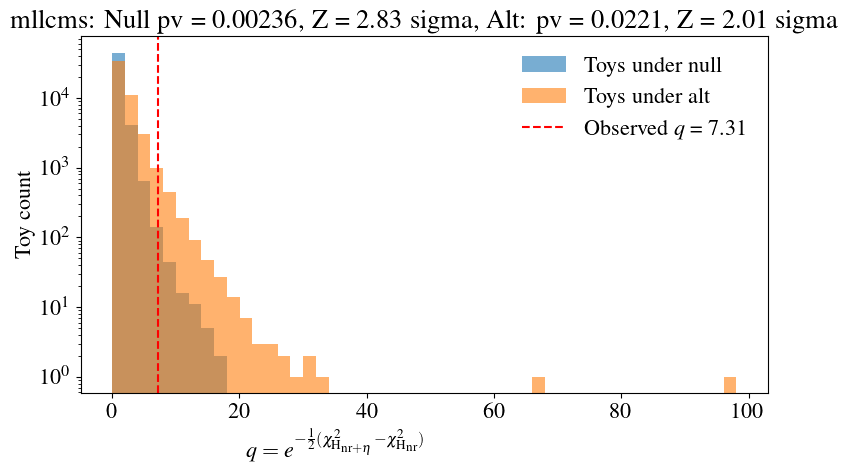

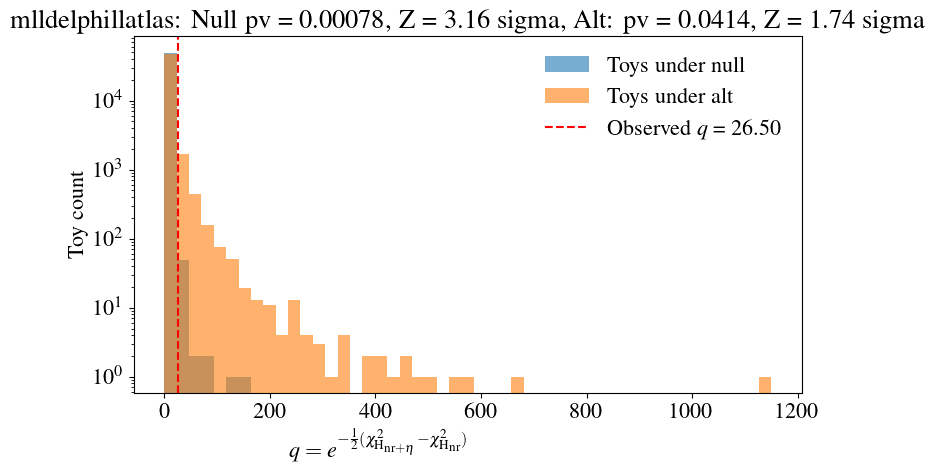

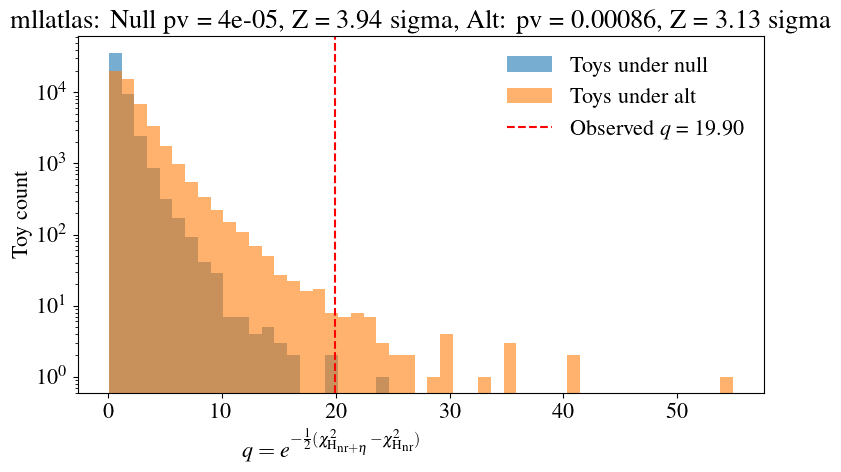

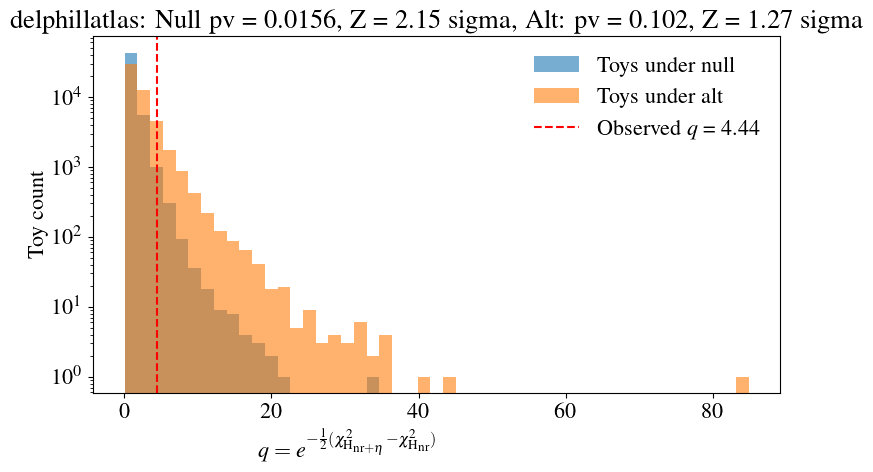

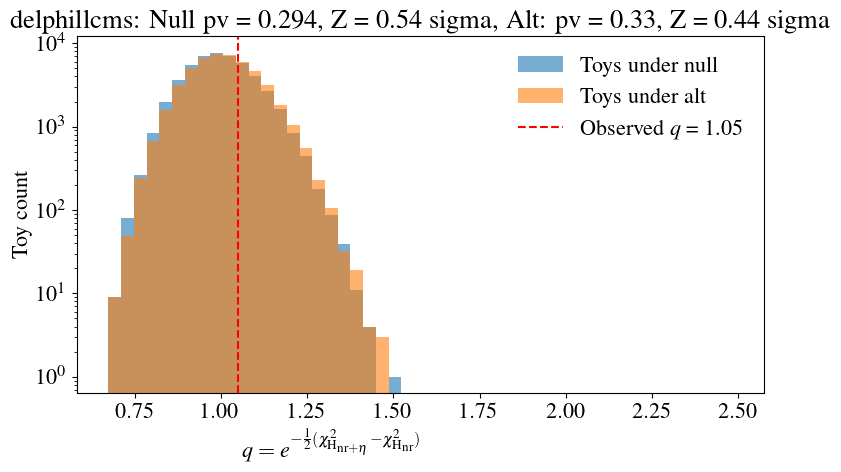

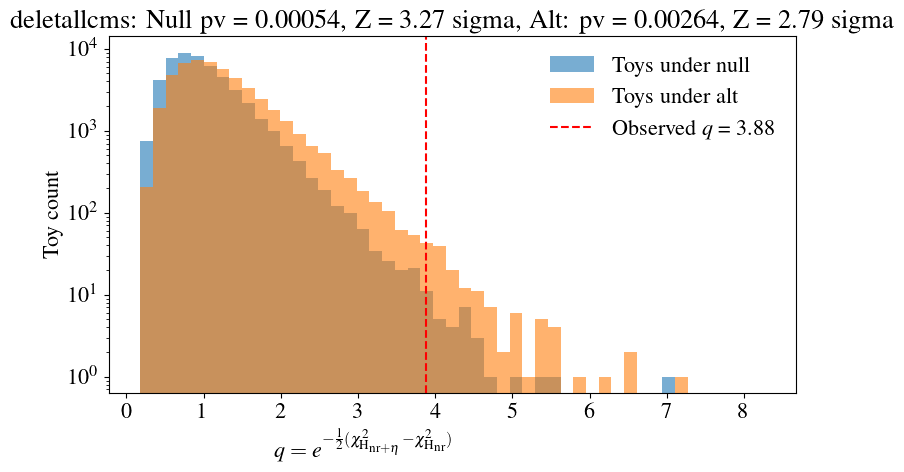

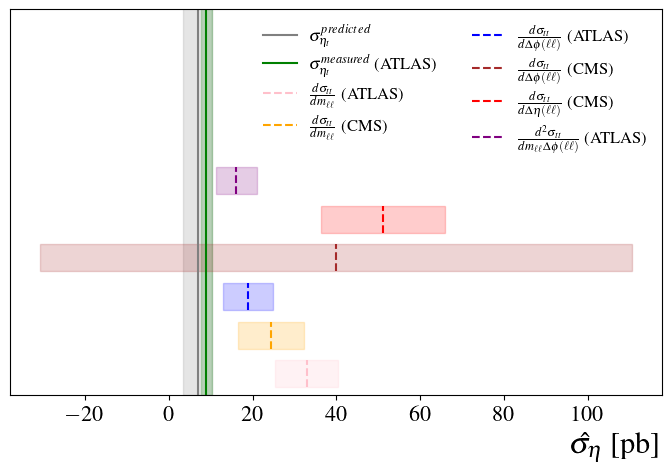

In [10]:
results_path = [ "mllcms_inputs.json",  "mlldelphillatlas_inputs.json",  "mllatlas_inputs.json", "delphillatlas_inputs.json",  "delphillcms_inputs.json",  "deletallcms_inputs.json" ]
cov_paths = ["cmsmll_cov.csv","", "","","cmsdelphill_cov.csv", "deletallcms_cov.csv"] #double check availability of ATLAS covariance matrices

for i in range(0, len(results_path)):
    print(f"Processing results: {results_path[i]}")

    if (results_path[i] == "mlldelphillatlas_inputs.json" ):
        input_data, data_values, NNLO_values, NNLO_toponium_values, cov_matrix = read_inputs(results_path[i], cov_paths[i], add_theory_uncertainties=False, renormalise=False, print_config=False)
    else:
        input_data, data_values, NNLO_values, NNLO_toponium_values, cov_matrix = read_inputs(results_path[i], cov_paths[i], add_theory_uncertainties=False, renormalise=True, print_config=False)
    alpha_range, delta_chi2, best_fit_val, alpha_low, alpha_high, fitted_prediction = chi2_fit(input_data, data_values, NNLO_toponium_values, NNLO_values, cov_matrix)
    plot_chi2_fit_result(input_data, results_path[i], alpha_range, delta_chi2, best_fit_val, alpha_low, alpha_high)
    plot_predictions_and_data(results_path[i], input_data, data_values, NNLO_values, NNLO_toponium_values, cov_matrix, fitted_prediction)
    q_null_toys, q_alt_toys, q_data, p_val_null, p_val_alt, Z_val_null , Z_val_alt = run_toys(data_values, NNLO_values, NNLO_toponium_values,  cov_matrix)
    plot_toys(results_path[i], q_null_toys, q_alt_toys, q_data, p_val_null, p_val_alt, Z_val_null , Z_val_alt)
    print(f" ")

result_files = ["mllatlas_results.txt" , "mllcms_results.txt",  "delphillatlas_results.txt", "delphillcms_results.txt", "deletallcms_results.txt", "mlldelphillatlas_results.txt"]
make_summary_plot(result_files)

stats_files = ["mllatlas_stats.txt" , "mllcms_stats.txt",  "delphillatlas_stats.txt", "delphillcms_stats.txt", "deletallcms_stats.txt", "mlldelphillatlas_stats.txt"]
generate_latex_summary_table(stats_files)

In [11]:
generate_latex_summary_table(stats_files)

✅ LaTeX table with merged hypothesis columns written to summary_table.tex
